# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion). 

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1] 
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$ 
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>
torch.Size([100, 1])
torch.Size([128, 1])
torch.Size([200, 128])
torch.Size([200, 100, 128])
torch.Size([1000, 128])
torch.Size([1000, 100, 128])


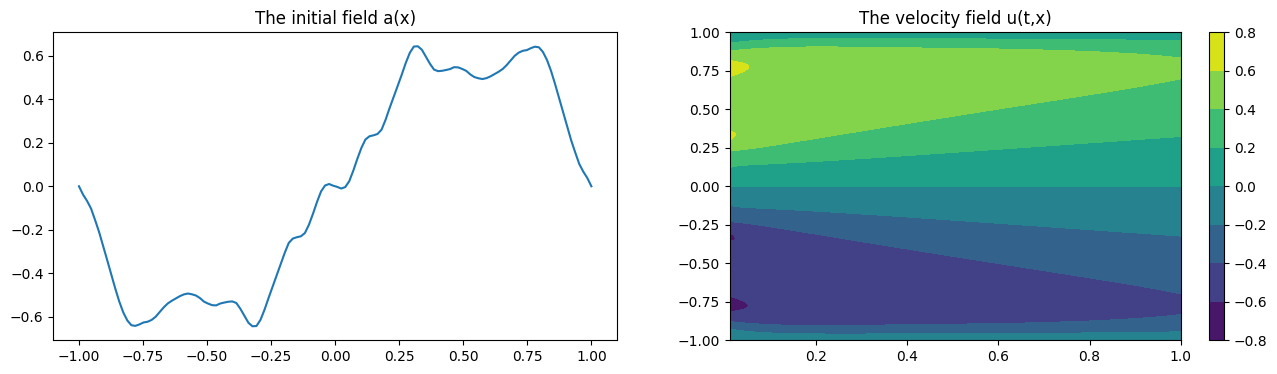

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('TrafficFlow.h5', 'r') as file:
    print(file.keys())
    t_mesh = torch.tensor(np.array(file['t_mesh']), dtype=dtype)
    x_mesh = torch.tensor(np.array(file['x_mesh']), dtype=dtype)
    a_test = torch.tensor(np.array(file['a_test']), dtype=dtype)
    u_test = torch.tensor(np.array(file['u_test']), dtype=dtype)
    a_train = torch.tensor(np.array(file['a_train']), dtype=dtype)
    u_train = torch.tensor(np.array(file['u_train']), dtype=dtype)
    #
    X, T = np.meshgrid(x_mesh, t_mesh)
#
print(t_mesh.shape)
print(x_mesh.shape)
print(a_test.shape)
print(u_test.shape)
print(a_train.shape)
print(u_train.shape)
#################################
inx = 0
fig, axes = plt.subplots(1,2, figsize=(16,4))
#
cntr = axes[0].plot(x_mesh, a_train[0])
axes[0].set_title('The initial field a(x)')
#
cntr = axes[1].contourf(T, X, u_train[inx])
axes[1].set_title('The velocity field u(t,x)')
plt.colorbar(cntr)
#
plt.show()

Epoch 1: Loss = 0.604933
Epoch 2: Loss = 0.126017
Epoch 3: Loss = 0.078725
Epoch 4: Loss = 0.081813
Epoch 5: Loss = 0.061117
Epoch 6: Loss = 0.055952
Epoch 7: Loss = 0.060385
Epoch 8: Loss = 0.058646
Epoch 9: Loss = 0.042495
Epoch 10: Loss = 0.038039
Epoch 11: Loss = 0.036839
Epoch 12: Loss = 0.035850
Epoch 13: Loss = 0.033745
Epoch 14: Loss = 0.030916
Epoch 15: Loss = 0.030182
Epoch 16: Loss = 0.029723
Epoch 17: Loss = 0.029777
Epoch 18: Loss = 0.030617
Epoch 19: Loss = 0.023625
Epoch 20: Loss = 0.023004


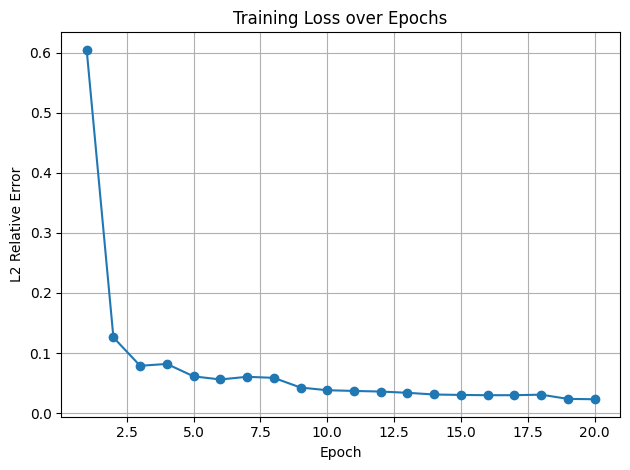

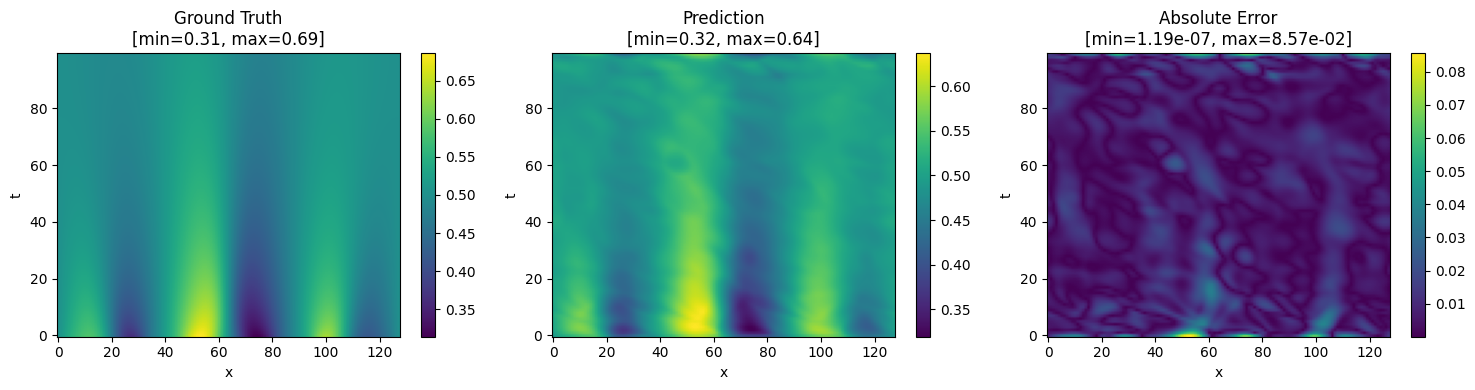


 Durchschnittlicher L2-Fehler auf dem Testset: 0.021493


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Problem C
class ProblemCDataset(torch.utils.data.Dataset):
    def __init__(self, h5_path, mode='train'):
        # Open the HDF5 file and load data
        with h5py.File(h5_path, 'r') as f:
            self.a = f[f'a_{mode}'][:]    # 1D input feature per sample, shape: [N, 128]
            self.u = f[f'u_{mode}'][:]    # Corresponding 2D output field, shape: [N, 100, 128]

        self.u_min = self.u.min()
        self.u_max = self.u.max()
        self.u = (self.u - self.u_min) / (self.u_max - self.u_min)

    def __len__(self):
        # Number of samples in the dataset
        return self.a.shape[0]

    def __getitem__(self, idx):
        # Extract one sample
        a_1d = self.a[idx].reshape(1, 128)  # Reshape to make it 2D
        a_grid = np.tile(a_1d, (100, 1))    # Repeat along time dimension to form 2D grid
        t_grid = np.linspace(0, 1, 100).reshape(-1, 1)  # Time values evenly spaced from 0 to 1
        t_grid = np.tile(t_grid, (1, 128)) 

        # Stack feature channels (a and t) together
        x = np.stack([a_grid, t_grid], axis=0)  # Shape: [2, 100, 128]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.u[idx], dtype=torch.float32)

# Spectral Convolution Layer for 2D data
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in dimensions
        self.modes2 = modes2  

        # Learnable complex weights in the Fourier domain
        self.weights1 = nn.Parameter(torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # Complex multiplication using Einstein summation notation
        return torch.einsum("bixy, ioxy -> boxy", input, weights)

    def forward(self, x):  # x shape: [B, C, H, W]
        B, C, H, W = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")
        
        # Initialize zero output in frequency domain
        out_ft = torch.zeros(B, self.out_channels, H, W//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2],
            self.weights1
        )

        # Inverse FFT to go back to spatial domain
        x = torch.fft.irfft2(out_ft, s=(H, W), norm="ortho")
        return x

# Full Fourier Neural Operator (FNO) Model
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super().__init__()
        self.width = width

        # Initial linear projection from input to desired width
        self.fc0 = nn.Linear(2, width)

        # Four spectral convolution blocks
        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        # 1x1 convolution layers
        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)

        # Final linear layers for pointwise prediction
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):  # Input shape: [B, 2, 100, 128]
        x = x.permute(0, 2, 3, 1)   # Rearrange to [B, 100, 128, 2]
        x = self.fc0(x)             # Project to higher-dimensional space
        x = x.permute(0, 3, 1, 2)   # Back to [B, width, 100, 128] for conv layers

        # Apply spectral convs + 1x1 convs + GELU nonlinearity
        x = F.gelu(self.conv0(x) + self.w0(x))
        x = F.gelu(self.conv1(x) + self.w1(x))
        x = F.gelu(self.conv2(x) + self.w2(x))
        x = F.gelu(self.conv3(x) + self.w3(x))

        # Prepare for final pointwise prediction
        x = x.permute(0, 2, 3, 1)   # [B, 100, 128, width]
        x = self.fc1(x)             # [B, 100, 128, 128]
        x = self.fc2(x)             # [B, 100, 128, 1]
        return x.squeeze(-1)        # [B, 100, 128], remove the last singleton dim

# Relative L2 Error (used as loss function)
def l2_relative_error(u_pred, u_true):
    # compares prediction error relative to the ground truth energy
    return torch.sqrt(torch.sum((u_pred - u_true)**2) / torch.sum(u_true**2))

# Training Loop
def train_model(model, dataloader, optimizer, loss_fn, epochs):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for x, u in dataloader:
            x, u = x.to(device), u.to(device)

            pred = model(x)                   # Forward pass
            loss = loss_fn(pred, u)          # Compute loss

            optimizer.zero_grad()            # Reset gradients
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights

            total_loss += loss.item()        # Keep track of loss

        # Average loss over the full epoch
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}")
    return loss_history

# Visualization of prediction vs ground truth
def plot_results(u_pred, u_true):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Plot Ground Truth
    im0 = axs[0].imshow(u_true.cpu().squeeze(), aspect='auto', origin='lower')
    axs[0].set_title(f"Ground Truth\n[min={u_true.min():.2f}, max={u_true.max():.2f}]")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('t')
    plt.colorbar(im0, ax=axs[0])

    # Plot Prediction
    im1 = axs[1].imshow(u_pred.cpu().squeeze().detach(), aspect='auto', origin='lower')
    axs[1].set_title(f"Prediction\n[min={u_pred.min():.2f}, max={u_pred.max():.2f}]")
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('t')
    plt.colorbar(im1, ax=axs[1])

    # Plot Absolute Error
    abs_err = torch.abs(u_true - u_pred)
    im2 = axs[2].imshow(abs_err.cpu().squeeze().detach(), aspect='auto', origin='lower')
    axs[2].set_title(f"Absolute Error\n[min={abs_err.min():.2e}, max={abs_err.max():.2e}]")
    axs[2].set_xlabel('x')
    axs[2].set_ylabel('t')
    plt.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

# Main Script
if __name__ == '__main__':
    torch.manual_seed(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Path to dataset
    data_path = r"C:\Users\malte\Desktop\OneDrive\TUM\01_Kurse\2_Semester\2_Deep Learning for PDE in Engineering Physics\Final_Project\Task_C\Data\TrafficFlow.h5"

    # Load training and test datasets
    train_dataset = ProblemCDataset(data_path, mode='train')
    test_dataset = ProblemCDataset(data_path, mode='test')

    # Prepare dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Initialize model and optimizer
    model = FNO2d(modes1=8, modes2=8, width=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model and record loss over epochs
    losses = train_model(model, train_loader, optimizer, l2_relative_error, epochs=20)

    # Plot training loss progression
    plt.figure()
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('L2 Relative Error')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Inference on the first test sample
    x, u = test_dataset[0]
    x = x.unsqueeze(0).to(device)
    u = u.unsqueeze(0).to(device)
    with torch.no_grad():
        u_pred = model(x)
    plot_results(u_pred, u)

    # Compute average test error
    model.eval()
    test_l2_errors = []
    with torch.no_grad():
        for x, u in test_loader:
            x, u = x.to(device), u.to(device)
            pred = model(x)
            test_l2_errors.append(l2_relative_error(pred, u).item())

    avg_test_l2 = np.mean(test_l2_errors)
    print(f"\n Durchschnittlicher L2-Fehler auf dem Testset: {avg_test_l2:.6f}")
